## Machine learning on EEG data

This tutorial walks through some basic tools for applying ML techniques on EEG data through MNE

### 1. Importing and preprocessing data

In [1]:
import mne

# Folder & files containing the data:
data_file = '817_1_PDDys_ODDBALL_Clean_curated'

# We read the EEG epochs:
epochs = mne.read_epochs(data_file + '.fif')

epochs = epochs['Standard', 'Novel']

epochs.filter(l_freq = 0.1, h_freq = 20)
epochs.apply_baseline((None, 0))

Reading 817_1_PDDys_ODDBALL_Clean_curated.fif ...
    Found the data of interest:
        t =    -100.00 ...     500.00 ms
        0 CTF compensation matrices available


<ipython-input-1-ad5cf6c242fb>:7: RuntimeWarning: This filename (817_1_PDDys_ODDBALL_Clean_curated.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(data_file + '.fif')


189 matching events found
No baseline correction applied
189 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Setting up band-pass filter from 0.1 - 20 Hz
l_trans_bandwidth chosen to be 0.1 Hz
h_trans_bandwidth chosen to be 5.0 Hz
Filter length of 16501 samples (33.002 sec) selected


<ipython-input-1-ad5cf6c242fb>:11: RuntimeWarning: filter_length (16501) is longer than the signal (301), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq = 0.1, h_freq = 20)


Applying baseline correction (mode: mean)


<EpochsFIF  |   160 events (all good), -0.1 - 0.5 sec, baseline [None, 0], ~22.2 MB, data loaded,
 'Novel': 30
 'Standard': 130>

The main information we wish to retain is (a) the data (b) the true labels

In [22]:
from sklearn.model_selection import train_test_split
import numpy as np

# and get the data:
data = epochs._data

n_timepoints = data.shape[2]-1
# and labels:
labels = epochs.events[:,-1]

# extract data along a window:
win_s = 5 # window size, ms
slide_s = 10 # sliding length, ms

cv_score = np.zeros((round(n_timepoints/win_s))) # initialize CV_Score for number of total windows

# slide and get data in our window of interest:
for indx, tp in enumerate(range(0,n_timepoints, win_s)):
    data_win = data[:,:,tp:tp+slide_s]
    # split to CV and test:
    data_CV, data_test, labels_CV, labels_test = train_test_split(data_win, labels, test_size=0.4, random_state=tp)
    clf = make_pipeline(Vectorizer(), StandardScaler(),
                    svm.SVC(kernel='linear',C=1)
                   )
    
    cv_score[indx] = np.mean(cross_val_score(clf, data_CV, labels_CV))

/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The defaul

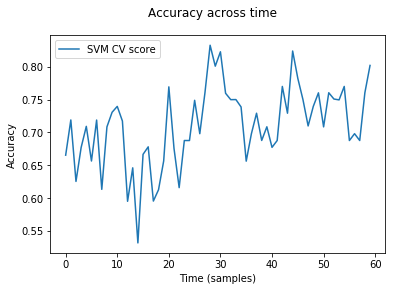

In [29]:
import matplotlib.pyplot as plt

%matplotlib inline

fig, ax = plt.subplots()
ax.plot(cv_score,label = 'SVM CV score')
ax.legend()
fig.suptitle('Accuracy across time')
plt.xlabel('Time (samples)')
plt.ylabel('Accuracy')
plt.show()